## Deep Hedging

Deep Hedging was proposed in [[1802.03042]](https://arxiv.org/abs/1802.03042)  by Hans Bühler, Lukas Gonon, Josef Teichmann and Ben Wood.

The idea is to use a neural network architecture to hedge a portfolio of derivatives without computing the "greeks".

This notebook is based on the lectures given by Josef Teichmann.

In [1]:
import numpy as np
import tensorflow as tf
import scipy.stats as scipy
import keras.backend as K
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Subtract, Multiply, Lambda, Add
from keras.backend import constant

from keras.models import Model
from keras.layers import Input
from keras import initializers

2023-09-08 14:09:05.888110: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 14:09:06.083631: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 14:09:06.086333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 14:09:08.204224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


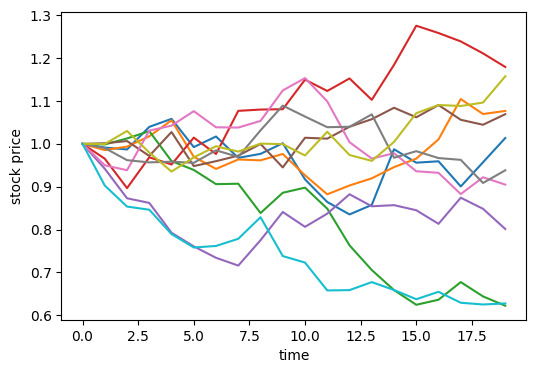

In [2]:
# Paths generated using the Black-Scholes model
# The trajectories are not needed afterwards

N = 20 # Time steps
S0 = 1 # Initial stock price
strike = 1 # Strike for the call option 
T = 1.0 # Maturity
sigma = 0.2 # Volatility
R = 10 # Number of paths

logS = np.zeros((N,R))
logS[0,] = np.log(S0)*np.ones((1,R))

for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
        logS[j+1,i] = logS[j,i]+increment
S = np.exp(logS)

# We plot the different paths
fig = plt.figure(figsize=(6,4)) 
ax = fig.add_subplot(1, 1, 1)
for i in range(R):
   plt.plot(S[:,i])
ax.set_xlabel('time')
ax.set_ylabel('stock price')
plt.show()


In [3]:
# Black-Scholes Call option price
def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))

# Initial price for the call option:
priceBS = BS(S0,strike,T,sigma)
print('Price of a Call option in the Black-Scholes model with initial price', S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))

Price of a Call option in the Black-Scholes model with initial price 1 strike 1 maturity 1.0 and volatility 0.2 is equal to 0.07965567455405798


In [4]:
# Definition of neural networks for hedging strategies

m = 1 # Dimension of price
d = 2 # Number of layers in strategy (depth)
n = 32 # Nodes in the first but last layers

# Architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh', trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1), 
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]


In [5]:
# Constructing the model and implementing the loss function
# Inputs contain: 1) The initial stock price S0
# 2) The initial hedging being 0 
# 3) The increments of the log price

price = Input(shape=(m,))
hedge = Input(shape=(m,))
inputs = [price]+[hedge]

# Strategy at j is the hedging strategy at j, i.e. the Neural Network g_j
for j in range(N):
    strategy = price
    for k in range(d):
        strategy = layers[k+(j)*d](strategy) 

    # Update the log price of the stock  
    incr = Input(shape=(m,))
    logprice = Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])

    # Update the price at time j+1
    pricenew = Lambda(lambda x : K.exp(x))(logprice)

    #Calculate the price increment 
    priceincr = Subtract()([pricenew, price])

    # Update the value of the hedge
    hedgenew = Multiply()([strategy, priceincr])

    # This is only used for m > 1:
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult)

    hedge = Add()([hedge, hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    price = pricenew

# Payoff of the call option
payoff = Lambda(lambda x : 0.5*(K.abs(x-strike) + (x-strike)) - priceBS)(price) 

# The output will be payoff-priceBS-hedge
# Loss function L = (payoff-priceBS-hedge)^2
outputs = Subtract()([payoff,hedge]) 

inputs = inputs
outputs = outputs

model_hedge = Model(inputs=inputs, outputs=outputs)

In [6]:
# Print summary of the model
model_hedge.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 add (Add)                      (None, 1)            0           ['lambda[0][0]',                 
                                                                  'input_3[0][0]']            

In [7]:
# Number of trainable paths. This number can be 1e6
Ktrain = 10**5 #2*10**4 #10**5  gives very good results

# Initial stock price
initialprice = S0

# xtrain consists of: 1) The stock price S0
# 2) Initial value of the Hedging is 0 
# 3) The increments of the log price process
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))] +
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain = np.zeros((Ktrain,1))

In [8]:
# ======= Train the model =======

# Optimizer: sgd
#sgd=optimizers.SGD(lr=0.0001)
#model_hedge.compile(optimizer=sgd,loss='mean_squared_error')

# Optimizer: adam
model_hedge.compile(optimizer='adam',loss='mean_squared_error')

for i in range(50):
    model_hedge.fit(x=xtrain,y=ytrain, epochs=1, verbose=True)
    print('Average value of the prediction =', np.mean(model_hedge.predict(xtrain)))

3125/3125 [==============================] - 12s 4ms/step
Average value of the prediction = 8.563238e-07
3125/3125 [==============================] - 12s 4ms/step
Average value of the prediction = 2.4127594e-05
3125/3125 [==============================] - 12s 4ms/step
Average value of the prediction = 1.4106679e-05
3125/3125 [==============================] - 12s 4ms/step
Average value of the prediction = -2.8179173e-05
3125/3125 [==============================] - 14s 4ms/step
Average value of the prediction = -1.4905783e-05
3125/3125 [==============================] - 10s 3ms/step
Average value of the prediction = 3.2747984e-08
3125/3125 [==============================] - 11s 3ms/step
Average value of the prediction = -2.658665e-07
3125/3125 [==============================] - 10s 3ms/step
Average value of the prediction = -7.8217774e-05
3125/3125 [==============================] - 11s 4ms/step
Average value of the prediction = 1.7128186e-05
3125/3125 [==============================] -

**Histogram of the predictions**

 - The results concentrate around zero
- Loss has a mean of 1e-5 which is already good

In [9]:
# ========= Generate predictions =========

# We generate a new set of paths to test the model        
xtest=([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))] +
          [np.random.normal(-(sigma)**2*T/(2*N),(sigma)*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ypred = model_hedge.predict(xtest)          


3125/3125 [==============================] - 10s 3ms/step


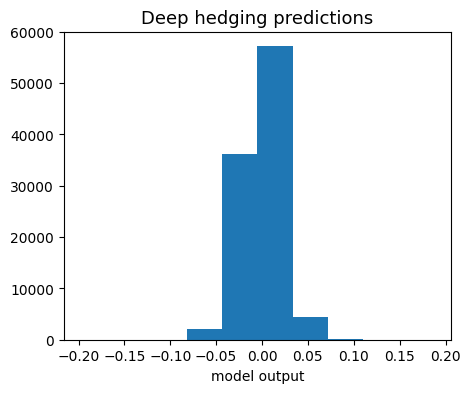

Standard deviation of prediction =  0.0203435
Average value of the prediction = -7.9399346e-05


In [10]:
# Histogram of the output of the model  
fig = plt.figure(figsize=(5,4)) 
ax = fig.gca()
plt.hist(ypred)
plt.title('Deep hedging predictions', fontsize=13, color='black')
ax.set_xlabel('model output')
plt.show()
print('Standard deviation of prediction = ', np.std(ypred))
print('Average value of the prediction =', np.mean(ypred))

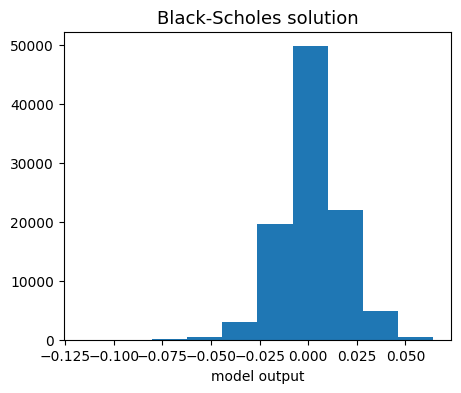

Standard deviation =  0.015461428641899205
Average value = 0.0020508674370250646


In [11]:
# Calculate the analytic hedge using Blach-Scholes solution for all the 'Ktrain' paths
logincrements = xtest[3:3+N]
hedge = np.zeros(Ktrain)
price = S0*np.ones((Ktrain,N))

# Loop that iterates over all time steps
for k in range(N-1):
    helper = logincrements[k][:,]
    helper = helper.transpose()
    price[:,k+1] = price[:,k]*np.exp(helper[:])

    # Call Option price as a function of time:
    hedge[:] = hedge[:] + scipy.norm.cdf((np.log(price[:,k]/strike)+0.5*(T-k*T/N)*sigma**2)/(np.sqrt(T-k*T/N)*sigma))*(price[:,k+1]-price[:,k])

# We add the initial (priceBS) and final condition (payoff)
hedge[:] = hedge[:]-0.5*(np.abs(price[:,N-1]-strike)+(price[:,N-1]-strike))+priceBS
fig = plt.figure(figsize=(5,4)) 
ax = fig.gca()
plt.hist(hedge)
plt.title('Black-Scholes solution', fontsize=13, color='black')
ax.set_xlabel('model output')
plt.show()

print('Standard deviation = ', np.std(hedge))
print('Average value =', np.mean(hedge))

In [12]:
# Get the weights of the model
weights = model_hedge.get_weights()
#print(weights)

# Use the weights to construct Delta(S)
# This works when the number of layers equals d=2
def deltastrategy(s,j):
    length = s.shape[0]
    g = np.zeros(length)
    for p in range(length):
        ghelper = np.tanh(s[p]*(weights[j*2*d])+weights[j*2*d+1])
        g[p] = np.sum(np.squeeze(weights[2*(d-1)+j*2*d])*np.squeeze(ghelper))
        g[p] = g[p]+weights[2*d-1+j*2*d]   
    return g

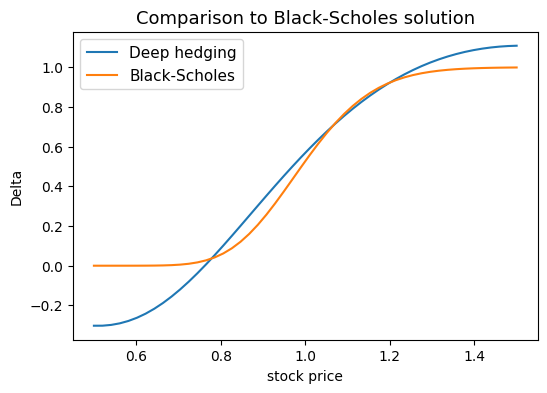

In [25]:
# Compare with the analytic Black-Scholes solution 

# Stock price vector
s = np.linspace(0.5, 1.5, 50)

# Select a random point in time [0,N-1]
k = 11

# Delta strategy obtained from the model weights
y = deltastrategy(s,k)

# Analytic Black-Scholes Delta(S)
z = scipy.norm.cdf((np.log(s/strike)+0.5*(T-k*T/N)*sigma**2)/(np.sqrt(T-k*T/N)*sigma))

fig = plt.figure(figsize=(6,4)) 
ax = fig.gca()        
plt.plot(s, y, label='Deep hedging')
plt.plot(s, z, label='Black-Scholes')
plt.title('Comparison to Black-Scholes solution', fontsize=13, color='black')
ax.set_xlabel('stock price')
ax.set_ylabel('Delta')
plt.legend(prop={'size':11})
plt.show()